# CMEPDA Project: image classification using Wavelet transform


Download data set from: https://drive.google.com/drive/folders/1wqp1YIcqSaoChZd7k7ikwylRFGIarKa6

## PyWavelet

This intial part introduces the wavelet transformation and some methods provided by the third part python package called pywalet.

**Useful links**
- **Wavelet transform**
  - https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
- **Pywavelets**:
  - https://pywavelets.readthedocs.io/en/latest/
  - https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html
  - https://pywavelets.readthedocs.io/en/latest/ref/dwt-coefficient-handling.html
  - https://pywavelets.readthedocs.io/en/v1.3.0_a/ref/2d-dwt-and-idwt.html
  - https://pywavelets.readthedocs.io/en/latest/ref/thresholding-functions.html

- **Pillow**:
  - https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html

### The different types of Wavelet families

The PyWavelets library for example contains 14 mother Wavelets (families of Wavelets):


In [2]:
import pywt
print(pywt.families(short=False))

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


Each type of wavelets has a different shape, smoothness and compactness and is useful for a different purpose.

Below we can see a plot with several different families of wavelets.
The first row contains four Discrete Wavelets and the second row four Continuous Wavelets.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


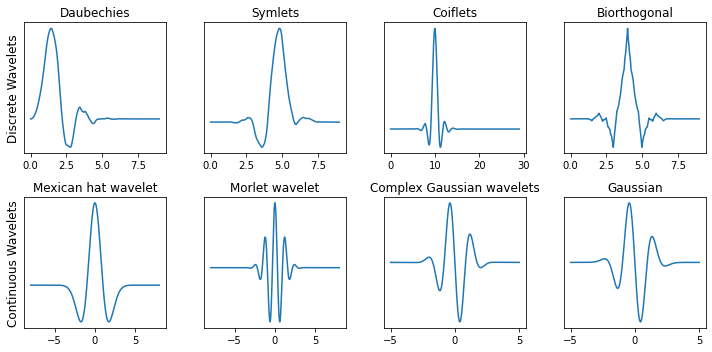

In [3]:
import matplotlib.pyplot as plt

discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
 
list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]
 
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(10,5))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=12)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=12)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=12)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
 
plt.tight_layout()
plt.show()

### Family of wavelets called ‘Daubechies’

Within each wavelet family there can be a lot of different wavelet subcategories belonging to that family. You can distinguish the different subcategories of wavelets by the number of coefficients (the number of vanishing moments) and the level of decomposition.

['db1', 'db2', 'db3', 'db4', 'db5']


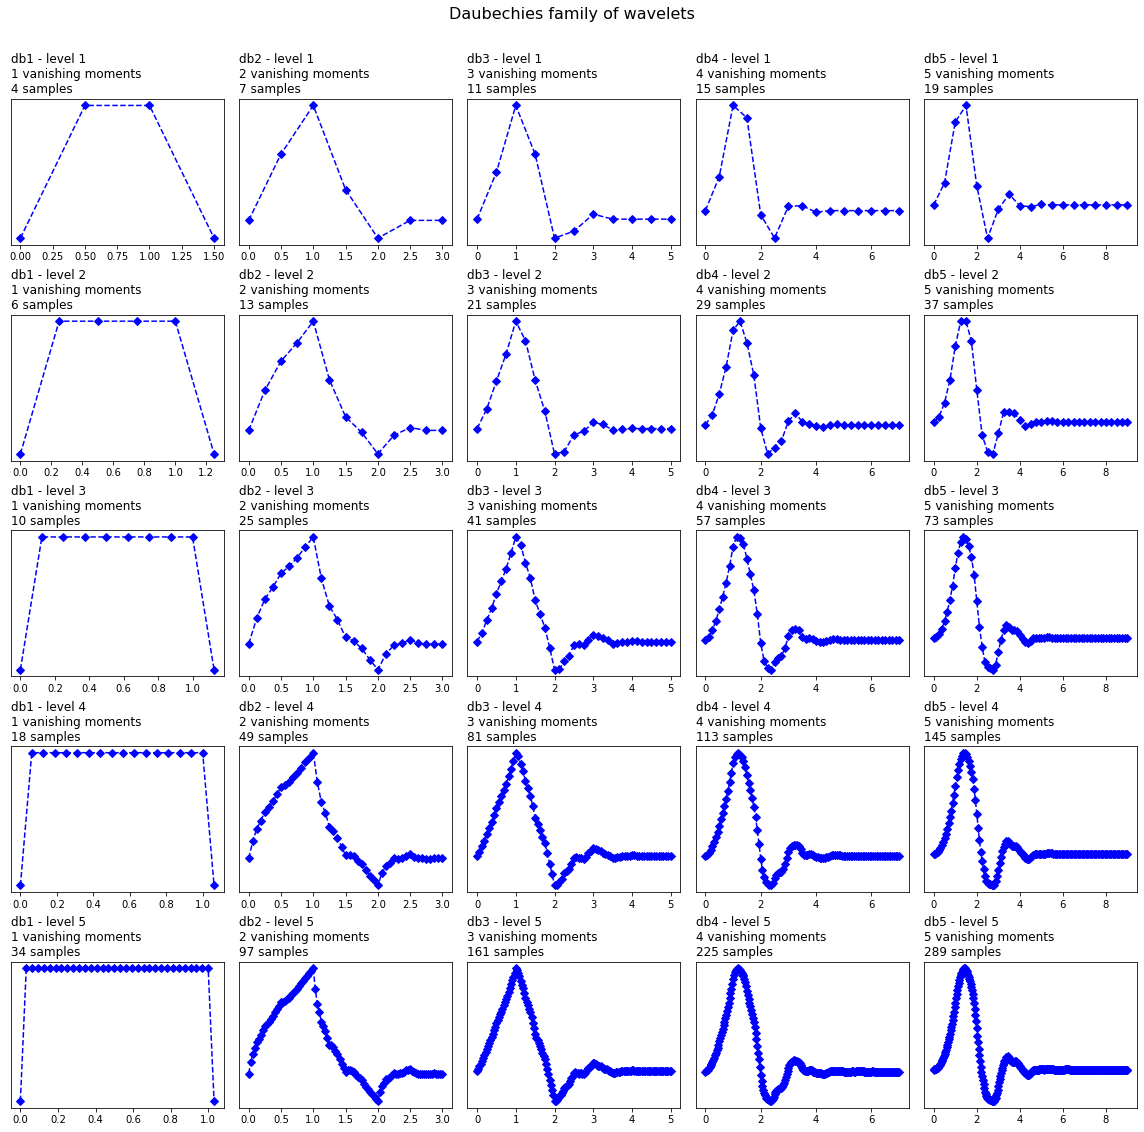

In [4]:
import matplotlib.pyplot as plt
 
db_wavelets = pywt.wavelist('db')[:5]

print(db_wavelets)
['db1', 'db2', 'db3', 'db4', 'db5']
 
fig, axarr = plt.subplots(ncols=5, nrows=5, figsize=(16,16))
fig.suptitle('Daubechies family of wavelets', fontsize=16)
for col_no, waveletname in enumerate(db_wavelets):
    wavelet = pywt.Wavelet(waveletname)
    no_moments = wavelet.vanishing_moments_psi
    family_name = wavelet.family_name
    for row_no, level in enumerate(range(1,6)):
        wavelet_function, scaling_function, x_values = wavelet.wavefun(level = level)
        axarr[row_no, col_no].set_title("{} - level {}\n{} vanishing moments\n{} samples".format(
            waveletname, level, no_moments, len(x_values)), loc='left')
        axarr[row_no, col_no].plot(x_values, wavelet_function, 'bD--')
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [5]:
# Create a Wavelet object
w = pywt.Wavelet('db5')
print(w)

Wavelet db5
  Family name:    Daubechies
  Short name:     db
  Filters length: 10
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


PS: We can also use pywt.wavedec() to immediately calculate the coefficients of a higher level. This functions takes as input the original signal and the level n and returns the one set of approximation coefficients (of the n-th level) and n sets of detail coefficients (1 to n-th level).

## Feature extraction

Extract from a mammogram the features to be submitted to the ML classiﬁer.

Implement a feature extraction based on the wavelet transform.

In [6]:
import os
import random
import glob

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import skimage
from skimage.io import imread
from numpy import asarray
import cv2
import matplotlib.image as mpimg
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import np_utils
import pywt

In [7]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Show coefficients of first level

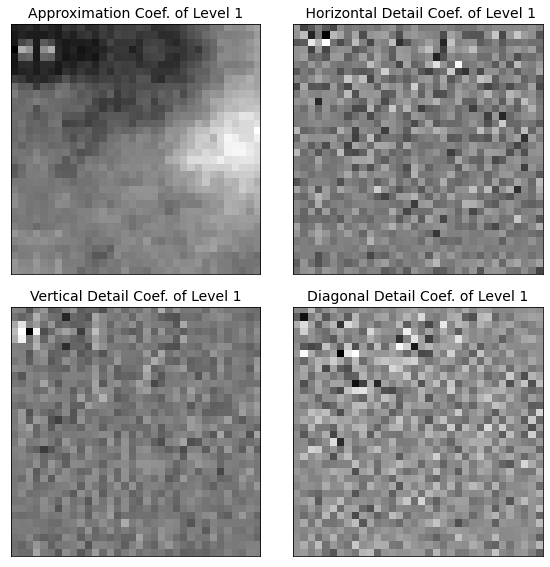

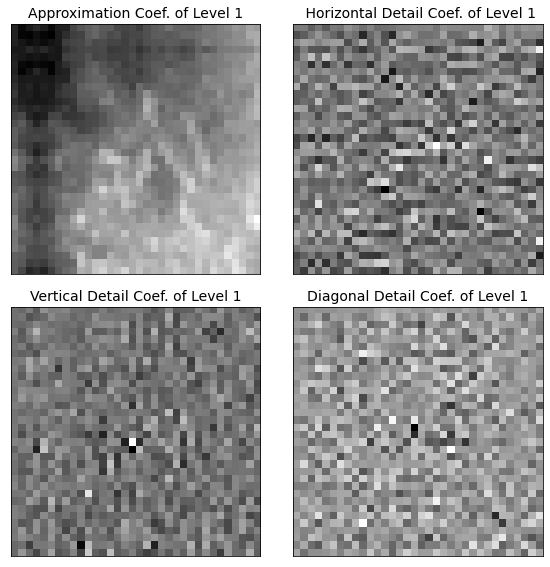

In [39]:
image1 = mpimg.imread("/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Train/0/0002s1_2_0.pgm_1.pgm")
image2 = mpimg.imread("/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Train/1/0006s1_1_1_1.pgm_1.pgm")
 
images=[image1,image2]

for image in images:
    image_array = Image.fromarray(image , 'L')
    resize_img = image_array.resize((60 , 60))
    
    # 2D Discrete Wavelet Transform
    coeffs2 = pywt.dwt2(resize_img, 'db5')  # https://pywavelets.readthedocs.io/en/v1.3.0_a/ref/2d-dwt-and-idwt.html
    cA, (cH, cV, cD) = coeffs2 # Approximation, horizontal detail, vertical detail and diagonal detail coefficients respectively.

    fig = plt.figure(figsize=(8, 8))
    # Wavelet transform of image, and plot approximation and details
    titles = ['Approximation Coef. of Level 1',
              ' Horizontal Detail Coef. of Level 1',
              'Vertical Detail Coef. of Level 1',
              'Diagonal Detail Coef. of Level 1'
              ]
    for i, a in enumerate([cA, cH, cV, cD]):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(a,  interpolation="nearest",cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()
    plt.show()

### Show coefficients of 4-th level

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


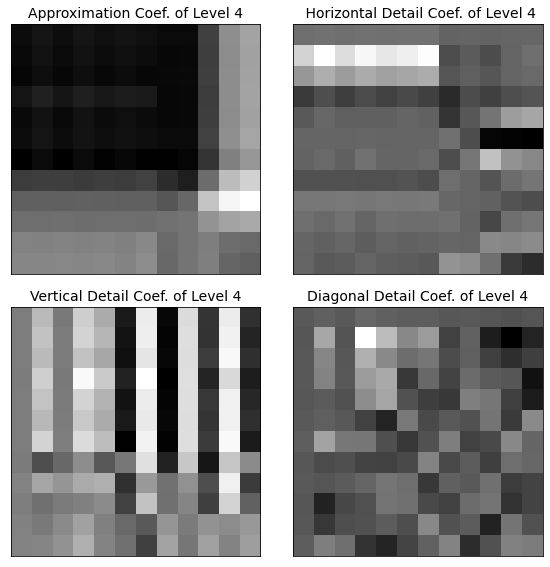

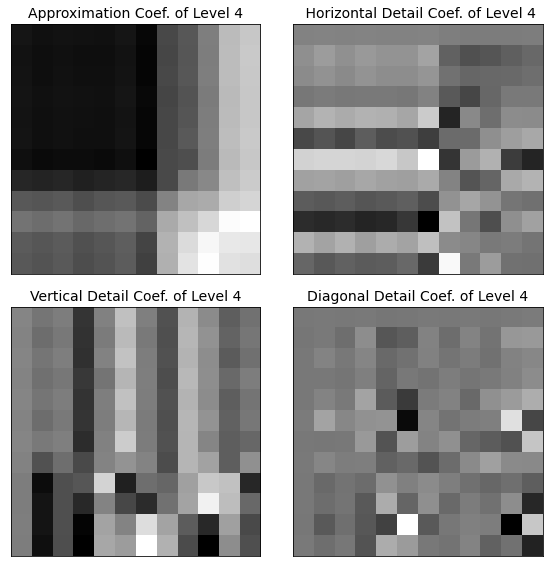

In [38]:
image1 = mpimg.imread("/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Train/0/0002s1_2_0.pgm_1.pgm")
image2 = mpimg.imread("/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Train/1/0006s1_1_1_1.pgm_1.pgm")
 
images=[image1,image2]

for image in images:
    image_array = Image.fromarray(image , 'L')
    resize_img = image_array.resize((60 , 60))
    
    # 2D Discrete Wavelet Transform
    # https://pywavelets.readthedocs.io/en/v1.3.0_a/ref/2d-dwt-and-idwt.html
    # Approximation, horizontal detail, vertical detail and diagonal detail coefficients respectively.
    cA, (cH4, cV4, cD4), (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = pywt.wavedec2(resize_img, 'db5', level=4)

    fig = plt.figure(figsize=(8, 8))
    # Wavelet transform of image, and plot approximation and details
    titles = ['Approximation Coef. of Level 4',
              ' Horizontal Detail Coef. of Level 4',
              'Vertical Detail Coef. of Level 4',
              'Diagonal Detail Coef. of Level 4'
              ]
    for i, a in enumerate([cA, cH4, cV4, cD4]):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(a,  interpolation="nearest",cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()
    plt.show()

### Multilevel decomposition

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


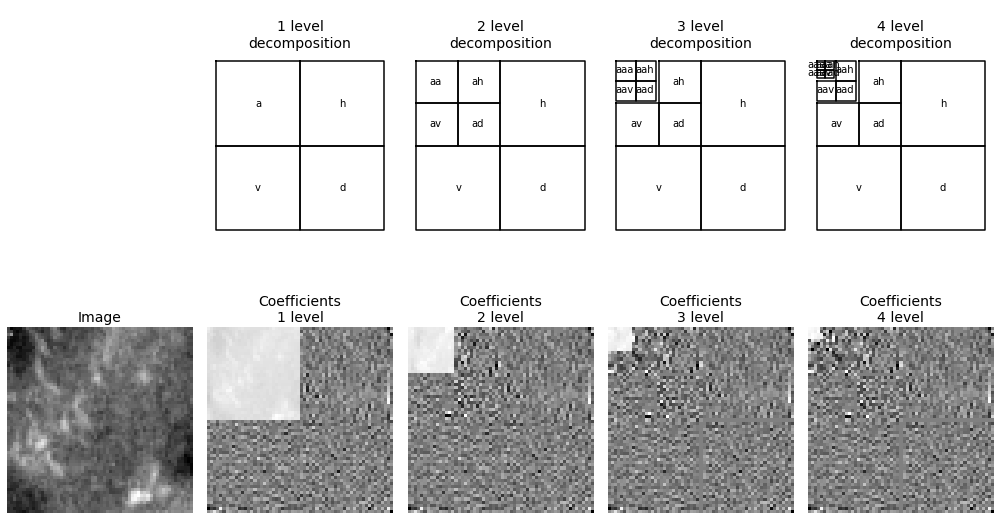

In [35]:
import numpy as np
import pywt
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

x = mpimg.imread('/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Train_png/1/0006s1_1_1_1.png_5.png')
shape = x.shape

max_lev = 4       # how many levels of decomposition to draw
label_levels = 4  # how many levels to explicitly label on the plots

fig, axes = plt.subplots(2, 5, figsize=[14, 8])
for level in range(0, max_lev + 1):
    if level == 0:
        # show the original image before decomposition
        axes[0, 0].set_axis_off()
        axes[1, 0].imshow(x, cmap=plt.cm.gray)
        axes[1, 0].set_title('Image', fontsize=14)
        axes[1, 0].set_axis_off()
        continue

    # plot subband boundaries of a standard DWT basis
    draw_2d_wp_basis(shape,
                     wavedec2_keys(level),
                     ax=axes[0, level],
                     label_levels=label_levels
                     )
    axes[0, level].set_title(f'{level} level\ndecomposition', fontsize=14)

    # compute the 2D DWT
    c = pywt.wavedec2(x, 'db5', mode='periodization', level=level)
    # normalize each coefficient array independently for better visibility
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    # show the normalized coefficients
    arr, slices = pywt.coeffs_to_array(c)
    axes[1, level].imshow(arr, cmap=plt.cm.gray)
    axes[1, level].set_title(f'Coefficients\n{level} level', fontsize=14)
    axes[1, level].set_axis_off()

plt.tight_layout()
plt.show()

In [12]:
import os
import random
import glob
import multiprocessing as mp

from PIL import Image
from skimage.restoration import denoise_wavelet
import skimage
from skimage import img_as_float
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import pywt
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn import metrics


In [13]:
TRAIN_PATH = '/content/gdrive/MyDrive/DATASETS_experim/IMAGES/Mammography_micro/Train'
TEST_PATH = '/content/gdrive/MyDrive/DATASETS_experim/IMAGES/Mammography_micro/Test'

### Function for wavelet coefficient extractions

In [14]:
def dwt_coeff(image, wavelet, level, partial=False):
    """
    This function collects all the coefficients of the 2DWT and converts them
    in a flat numpy array which can be passed to the binary classifier.

    Parameters
    ----------
    image :  Image object
        Image opened with PIL.Image.
    wavelet : str
        Wavelet family to use.
    level : int
        Level of the wavelet decomposition.
    partial : bool
        If True AND level = 3, take only the 2nd and 3rd levels coeffiecients
        without the 1st level ones and without those related to the approximated image;
        if True AND level = 4, take only the 2nd and 3rd and 4th levels coefficients
        levels without the 1st level ones and without those related to the approximated image;
        if False take all the coefficients obtained from the 2DWT decomposition.

    Returns
    -------
    coeffsarray : numpy array
        Flat numpy array containing all the coefficients of the 2DWT of the given image

    """

    coeffs = pywt.wavedec2(image, wavelet, level=level)
    infocoeffs = pywt.ravel_coeffs(coeffs)
    # https://pywavelets.readthedocs.io/en/latest/ref/dwt-coefficient-handling.html
    # ravel_coeffs: Wavelet transform coefficient array. All coefficients have been concatenated into a single 1D array.

    if partial == False:
        coeffsarray = infocoeffs[0]

    if partial == True:
        secondlevelcoeffs = np.concatenate((infocoeffs[0][infocoeffs[1][-2]['da']],
                                            infocoeffs[0][infocoeffs[1][-2]['ad']], 
                                            infocoeffs[0][infocoeffs[1][-2]['dd']]))
        thirdlevelcoeffs = np.concatenate((infocoeffs[0][infocoeffs[1][-3]['da']],
                                           infocoeffs[0][infocoeffs[1][-3]['ad']], 
                                            infocoeffs[0][infocoeffs[1][-3]['dd']]))
        if level == 3:    
            coeffsarray = np.concatenate((secondlevelcoeffs, thirdlevelcoeffs))
        
        elif level == 4:
            fourthlevelcoeffs = np.concatenate((infocoeffs[0][infocoeffs[1][-4]['da']],
                                                infocoeffs[0][infocoeffs[1][-4]['ad']], 
                                                infocoeffs[0][infocoeffs[1][-4]['dd']]))
            coeffsarray = np.concatenate((secondlevelcoeffs, thirdlevelcoeffs, fourthlevelcoeffs))
        else:
            pass
    
    return coeffsarray

In [15]:
PATH = '/content/gdrive/MyDrive/DATASETS_experim/IMAGES/Mammography_micro'

def read_img(image_path):
  # Creating a list of all image names found in image_path
  imagefilename = glob.glob(os.path.join(image_path, '*.pgm'))

  # Defining 4 sub-processes and apply Immage.open to all the images found
  pool = mp.Pool(processes=4)
  results = pool.map_async(Image.open, imagefilename)

  # Gets the list of images
  images = results.get()

  # Creates the list of corrisponding labels and convert it to numpy array
  label = os.path.basename(image_path)
  y = [int(label)] * len(images)
  y_np = np.array(y)

  return images, y_np

## Load image data set

In [16]:
image_path = os.path.join(PATH, 'Train/0')
X0_train, y0_train = read_img(image_path)

image_path = os.path.join(PATH, 'Train/1')
X1_train, y1_train = read_img(image_path)

# Creates a list containing both 0 and 1 labelled images
# and an array containing both 0 and 1 labels associated to the images.
X_train = X0_train + X1_train
y_train = np.concatenate((y0_train, y1_train))

image_path = os.path.join(PATH, 'Test/0')
X0_test, y0_test = read_img(image_path)

image_path = os.path.join(PATH, 'Test/1')
X1_test, y1_test = read_img(image_path)

X_test = X0_test + X1_test
y_test = np.concatenate((y0_test, y1_test))

X_tot = X_test + X_train # Images
labels = np.concatenate((y_test, y_train)) # Labels

## Compute the wavelet coefficients

In [17]:
wavelet = 'db5'
level = 4
partial = True

# List for coefficients
coefficients = []

# Compute the coefficients obtained from wavelet decomposition
for i, image in enumerate(X_tot):
  array = dwt_coeff(X_tot[i], wavelet, level, partial)
  coefficients.append(array)

coefficients = np.array(coefficients)

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


In [18]:
print(coefficients.shape)

(797, 2430)


# Binary Classification

Evaluate the performance of a machine learing technique on a microcalcification image dataset, where the mammographic images containing either microcalcifications or normal tissue are represented in terms of wavelet coefficients.

## Evaluation of binary classifiers

We can evaluate a binary classifier based on the following parameters:

- True Positive (**TP**): The mammography contains the *microcalcification cluster* and the model predicts "1"
- False Positive (**FP**): The mammography contains *normal tissue* but the model predicts "1"
- True Negative (**TN**): The mammography contains *normal tissue* and the model predicts "0"
- False Negative (**FN**): The mammography contains the *microcalcification cluster* and the model predicts "0"

After obtaining these values, we can compute the **accuracy** score of the binary classifier as follows:


$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$

The most common methods used in machine learning to binary classification:

- Support Vector Machines
- Naive Bayes
- Nearest Neighbor
- Decision Trees
- Logistic Regression
- Neural Networks




### Step 1: Define X (wavelet coefficients) and y (labels) variables



In [19]:
X = coefficients
y = labels

### Step 2: Split the dataset into training and testing sets

We use 75% of data for training and 25% for testing.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Step 3: Normalize the data for numerical stability

Normalize after splitting the data. It's good practice to apply any data transformations to training and testing data separately to prevent *data leakage*.

Data leakage is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.



In [21]:
from sklearn.preprocessing import StandardScaler

ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)

### Step 4: Fit a logistic regression model to the training data

This step trains the model to predict the targets from the data.



In [22]:
# Create a RandomForest Classifier
clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

RandomForestClassifier()

### Step 5: Make predictions on the testing data

With the model trained, we now ask to predict targets based on the test data.



In [23]:
y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.895


### Step 6: Calculate the accuracy score by comparing the actual values and predicted values

We can now calculate how well the model performed by comparing the model's predictions to the true target values, which we reserved in the y_test variable.

First, we'll calculate the confusion matrix to get the necessary parameters:


In [24]:
cm = confusion_matrix(y_test, y_pred)

TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

True Positive(TP)  =  86
False Positive(FP) =  9
True Negative(TN)  =  93
False Negative(FN) =  12


Confusion matrix, without normalization
[[93  9]
 [12 86]]


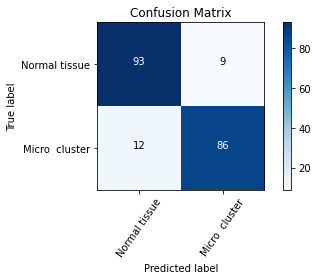

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(y_test, y_pred)
cm_plot_label =['Normal tissue', 'Micro  cluster']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix')

We can now calculate an accuracy score:



In [26]:
accuracy =  (TP + TN) / (TP + FP + TN + FN)
print(f'Accuracy of the binary classifier = {accuracy:.3f}')

Accuracy of the binary classifier = 0.895


## Other binary classifiers in the scikit-learn library

Compare several of the most common classification algorithms defined in Scikit-learn.

### Initializing each binary classifier

Initialize each model and store it by name in a dictionary in order to train each model in a loop.

In [27]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

# 
from sklearn.neural_network import MLPClassifier
models['MLPClassifier'] = MLPClassifier()


### Performance evaluation of each binary classifier

Once the models have been initialized, we can loop over each one, train it, make predictions, calculate metrics, and store each result in a dictionary.



In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

accuracy, precision, recall, roc_auc = {}, {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    roc_auc[key] = roc_auc_score(predictions, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Use pandas to view all the stored metrics as a table:


In [29]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'AUC'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['AUC'] = roc_auc.values()

df_model

,Accuracy,Precision,Recall,AUC
Logistic Regression,0.615,0.571429,0.615385,0.615032
Support Vector Machines,0.625,0.571429,0.629213,0.625418
Decision Trees,0.740,0.704082,0.750000,0.740741
Random Forest,0.895,0.918367,0.873786,0.895656
Naive Bayes,0.870,0.785714,0.939024,0.880529
K-Nearest Neighbor,0.515,0.010204,1.000000,0.756281
MLPClassifier,0.640,0.591837,0.644444,0.640404


In [30]:
# Render object to a LaTeX tabular

df = pd.DataFrame(dict(df_model))
print(df.to_latex(index=False))

# NB: Requires \usepackage{booktabs}.

\begin{tabular}{rrrr}
\toprule
 Accuracy &  Precision &   Recall &      AUC \\
\midrule
    0.615 &   0.571429 & 0.615385 & 0.615032 \\
    0.625 &   0.571429 & 0.629213 & 0.625418 \\
    0.740 &   0.704082 & 0.750000 & 0.740741 \\
    0.895 &   0.918367 & 0.873786 & 0.895656 \\
    0.870 &   0.785714 & 0.939024 & 0.880529 \\
    0.515 &   0.010204 & 1.000000 & 0.756281 \\
    0.640 &   0.591837 & 0.644444 & 0.640404 \\
\bottomrule
\end{tabular}



 Plot a bar chart to compare the classifiers' performance:



(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text major ticklabel objects>)

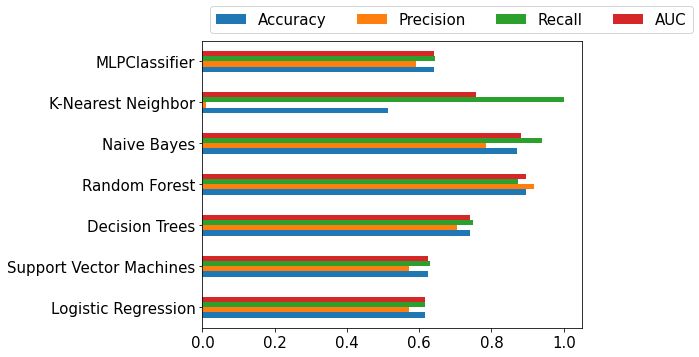

In [31]:
ax = df_model.plot.barh(figsize=(8, 5))
ax.legend(
    ncol=len(models.keys()), 
    bbox_to_anchor=(0, 1), 
    loc='lower left', 
    prop={'size': 15}
    )
plt.tight_layout()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

Since we're only using the default model parameters, we won't know which classifier is better. We should optimize each algorithm's parameters first to know which one has the best performance.



## k-fold cross Validation

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import numpy as np
from numpy import interp

In [33]:
def plot_cv_roc(X, y, classifier, n_splits=5):

  try:
    y = y.to_numpy()
    X = X.to_numpy()
  except AttributeError:
    pass
  
  cv = StratifiedKFold(n_splits)

  tprs = [] #True positive rate
  aucs = [] #Area under the ROC Curve
  interp_fpr = np.linspace(0, 1, 100)
  plt.figure()
  i = 0
  for train, test in cv.split(X, y):
    
    model = classifier
    prediction = model.fit(X[train], y[train])

    y_test_pred = model.predict(X[test])

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y[test], y_test_pred)
    interp_tpr = interp(interp_fpr, fpr, tpr)
    tprs.append(interp_tpr)
    
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
            label=f'ROC fold {i} (AUC = {roc_auc:.2f})')
    i += 1
  
  plt.legend()
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.show()

  plt.figure()
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(interp_fpr, mean_tpr)
  std_auc = np.std(aucs)
  plt.plot(interp_fpr, mean_tpr, color='b',
          label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate',fontsize=18)
  plt.ylabel('True Positive Rate',fontsize=18)
  plt.title('Cross-Validation ROC of RandomForestClassifier',fontsize=18)
  plt.legend(loc="lower right", prop={'size': 15})
  plt.show()

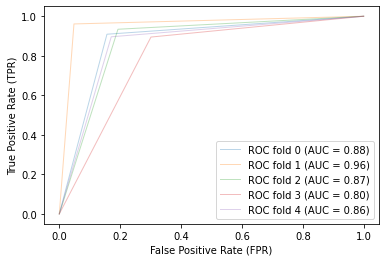

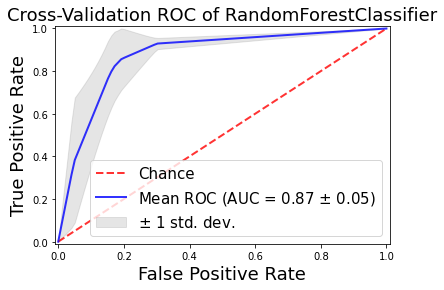

In [34]:
classifier = RandomForestClassifier()
plot_cv_roc(X, y, classifier, 5)